<a href="https://colab.research.google.com/github/chandrakiranck/fuzzy-adventure/blob/master/DIABMED_cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports
 
We will use the standard data science and machine learning libraries: `numpy`, `pandas`, and `scikit-learn`. We also use `matplotlib` and `seaborn` for visualization. 

In [0]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 20

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 1.2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve

# Data Cleaning and Formatting

## Load in the Data and Examine

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science. Think of it as a spreadsheet within Python that we can easily manipulate, clean, and visualize. [Pandas has many methods](http://pandas.pydata.org/pandas-docs/stable/) to help make the data science/machine learning pipeline as smooth as possible.

In [0]:
# Read in data into a dataframe 
data=pd.read_csv("diabetic_data.csv")
# Display top of dataframe
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


Taking a look at the raw data, we can already see a number of issues we'll have to solve. First of all, there are 50 columns and we don't know what many of them mean! All we know from the problem statement is that we want to predict the number in the score column. Some of the other column definitions can be reasonably guessed, but others are difficult to understand. In machine learning, this isn't actually a problem, because we let the model decide which features are important. Sometimes we may not even be given column names or told what we are predicting. Nonetheless, I like to understand the problem to the extent possible, and because we also want to interpret the model results, it would be a good idea to have some knowledge of the columns.

In [0]:
data["diabetesMed"].value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

## Data Types and Missing Values

The `dataframe.info` method is a quick way to assess the data by displaying the data types of each column and the number of non-missing values. Already from looking at the dataframe, there might be a problem because the missing values are coded as "?" rather than as `np.nan` (not a number). This means the columns with numbers will not be represented as numeric because pandas converts columns with any strings values into columns of all strings.

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

Sure enough, there are a number of columns with numbers that have been recorded as object datatypes. These will have to be converted to float datatype before we can do any numerical analysis.


##**Missing values**:
will do replace missing values and "**?**" with "**np.NaN**"


In [0]:
data.replace("?",np.NaN,inplace=True)

Now that we have the correct column datatypes, we can start analysis by looking at the percentage of missing values in each column. Missing values are fine when we do Exploratory Data Analysis, but they will have to be filled in for machine learning methods.

Following is a function that calculates the number of missing values and the percentage of the total values that are missing for each column. As with many tasks in data science, I did not write this function myself, but rather found it online in a [Stack Overflow forum](https://stackoverflow.com/a/39734251)! 

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [0]:
missing_values_table(data)

Your selected dataframe has 50 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
weight,98569,96.9
medical_specialty,49949,49.1
payer_code,40256,39.6
race,2273,2.2
diag_3,1423,1.4
diag_2,358,0.4
diag_1,21,0.0


Although we want to be careful to not discard information and should be careful when dropping columns, if a column has a high percentage of missing values, then it probably will not be of much use.

What columns to retain may be a little arbitrary (here is a discussion), but for this project, we will remove any columns with more than 30% missing values. In general, be careful about dropping any information because even if it is not there for all the observations, it may still be useful for predicting the target value.

In [0]:
# Get the columns with > 30% missing
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 30].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 50 columns.
There are 7 columns that have missing values.
We will remove 3 columns.


In [0]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

The rest of the missing values will have to be imputed (filled-in) using an appropriate strategy before doing machine learning.

In [0]:
data.dropna(inplace=True)

data.index = range(len(data))

in our data the missing value percentages are less than 4%. So , we droping it incase of imputing..

### **Convert Data to Correct Types and Fearure Engineering**

We convert the columns with numbers into numeric data types by replacing the strings which can be interpreted as floats. Then we will convert the columns that contain numeric values into numeric datatypes.

**Feature Engineering:** The process of taking raw data and extracting or creating new features that allow a machine learning model to learn a mapping beween these features and the target. This might mean taking transformations of variables, such as we did with the log and square root, or one-hot encoding categorical variables so they can be used in a model. Generally, I think of feature engineering as adding additional features derived from the raw data.

In this project, we will take the following steps for feature engineering:

*   Convert object type variables to numerical.
*   Label encode the categorical variables for achieving point 1.
*   Group similar data.

**Note:**
We will label encode the variables 'race', 'diag_1', 'diag_2' and 'diag_3' after our EDA.

We convert the columns with numbers into numeric data type and we replacing the data E and V with "-" and the value 250.xx changing to 250.

In [0]:
#Tranform of Age
spiltted_age = data['age'].str[1:-1].str.split('-')

for i in range(len(spiltted_age)):
    value_1 = (int)(spiltted_age[i][0])
    value_2 = (int)(spiltted_age[i][1])
    data['age'][i] = (value_1+value_2)/2

data["age"]=data["age"].astype(int)

In [0]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    data[col] = data[col].str.replace('E','-')
    data[col] = data[col].str.replace('V','-')
    condition = data[col].str.contains('250')
    data.loc[condition,col] = '250'
data[diag_cols] = data[diag_cols].astype(float)

**International Classification of Diseases (ICD)** is the international "standard diagnostic tool for epidemiology, health management and clinical purposes." Its full official name is International Statistical Classification of Diseases and Related Health Problems.


The diagnostic codes used by MSP are based on the ninth revision of the International Classification of Diseases developed by the World Health Organization, commonly referred to as ICD9.For codes and related diseases, please refer to the following link -
[https://www2.gov.bc.ca/assets/gov/health/practitioner-pro/medical-services-plan/diag-codes-index.pdf]
source:British Council

We will group the various codes of diagnosis according to ICD-9 standard.

In [0]:
# Function to group diag_1, diag_2 and diag_3

def grouping(value):
    if value==250:
        return 'Diabetes'
    elif (value>=390 and value<=459) or (value==785):
        return 'Circulatory'
    elif (value>=460 and value<=519) or value==786:
        return 'Respiratory'
    elif (value>=520 and value<=579) or value==787:
        return 'Digestive'
    elif (value>=800 and value<=999):
        return 'Injury'
    elif (value>=710 and value<=739):
        return 'Musculoskeletal'
    elif (value>=580 and value<=629) or value==788:
        return 'Genitourinary'
    elif (value>=1 and value<=239) or value in [780,781,782,784] or (value>=790 and value<=799) or ((value>=240 and value<=279) and 
                                                                                           value!=250) or (value>=680 and 
                                                                                                          value<=709):
        return 'Neoplasms'
    else:
        return "Other"

In [0]:
for col in diag_cols:
  data[col]=data[col].apply(grouping)

In [0]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,15,1,1,7,3,59,0,18,0,0,0,Neoplasms,Diabetes,Neoplasms,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,11,5,13,2,0,1,Other,Diabetes,Other,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,35,1,1,7,2,44,1,16,0,0,0,Neoplasms,Diabetes,Circulatory,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,45,1,1,7,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,55,2,1,2,3,31,6,16,0,0,0,Circulatory,Circulatory,Diabetes,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30


values of ages we are dealing with spliting the age and using its mean as age.

**values of max_glu_serum** :
The blood sugar level, blood sugar concentration, or blood glucose level is the concentration of glucose present in the blood of humans and other animals. Glucose is a simple sugar and approximately 4 grams of glucose are present in the blood of a 70-kilogram (150 lb) human at all times.[2] The body tightly regulates blood glucose levels as a part of metabolic homeostasis.[2] Glucose is stored in skeletal muscle and liver cells in the form of glycogen;[2] in fasted individuals, blood glucose is maintained at a constant level at the expense of glycogen stores in the liver and skeletal muscle. source:wikipedia

(https://www.sciencedirect.com/topics/immunology-and-microbiology/glucose-level)

In [0]:
data['max_glu_serum'] = data['max_glu_serum'].replace({'>200':"high",'>300':"veryhigh"})

**values for A1C test result**:

The A1C test is a blood test that provides information about your average levels of blood glucose, also called blood sugar, over the past 3 months. The A1C test can be used to diagnose type 2 diabetes and prediabetes.1 The A1C test is also the primary test used for diabetes management.

In [0]:
data['A1Cresult'] = data['A1Cresult'].replace({'>7':"high",'>8':"veryhigh"})

**Change of medications**:   Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”.

In [0]:
data['change'] = data['change'].replace({'No':0,'Ch':1})

**Diabetes medications**:	Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”

In [0]:
data['diabetesMed'] = data['diabetesMed'].replace({'No':0,'Yes':1})

**Values of Medications**: For the generic names: ***metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone***, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed

In [0]:
# Transforamtion for medications

data.iloc[:,21:44] = data.iloc[:,21:44].replace({'Up':3, 'Down':1, 'Steady':2, 'No':0})

In [0]:
# Transforamtion of  age

data=data[(data['gender'] == "Male")| (data['gender'] =="Female")]
#data['gender'] = data['gender'].replace({'Male':0,'Female':1})

In [0]:
data['readmitted'] = data['readmitted'].replace({'NO':0,'>30':1,"<30":2})

In the readmission transforamtion we transformed our data fo no as 0 and yes for 1

In [0]:
data['race'] = data['race'].replace({'Hispanic':"Other",'Asian':"Other"})

In [0]:
data["race"].value_counts()

Caucasian          75079
AfricanAmerican    18881
Other               4092
Name: race, dtype: int64

### **Exploratory Data Analysis**
Exploratory Data Analysis (EDA) is an open-ended process where we make plots and calculate statistics in order to explore our data. The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine.


1    0.76847
0    0.23153
Name: diabetesMed, dtype: float64


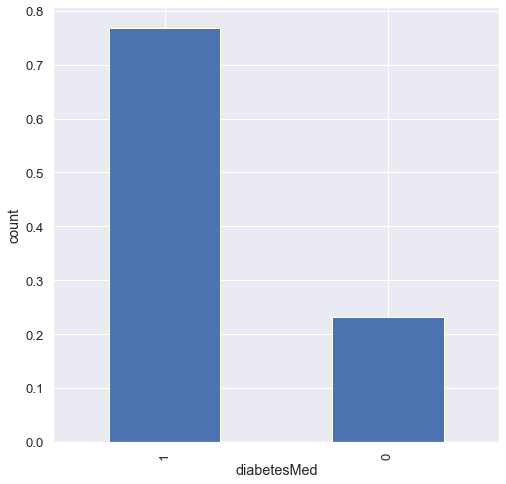

In [0]:
plt.figure(figsize=(8,8))
print(data['diabetesMed'].value_counts(normalize=True))
data['diabetesMed'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("diabetesMed")
plt.ylabel("count")
plt.show()

**Inferences:**



1.   The number of patients who were prescribed with diabetic medication are 30% more than patients who were not prescribed.

2.   The target variable is not balanced.



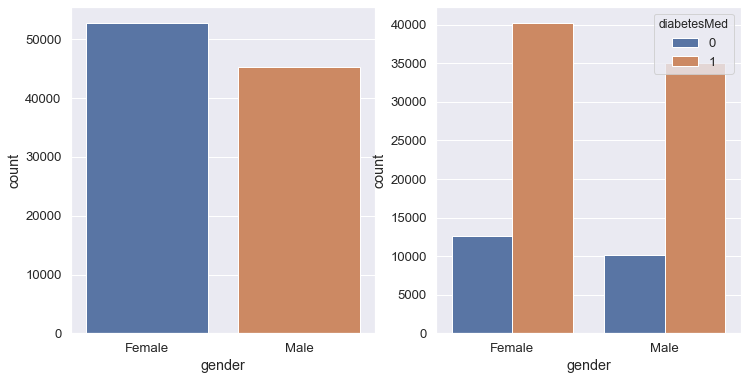

In [0]:
# Count plot of Gender by readmission status

f, axes = plt.subplots(1, 2, figsize=(12,6))
axes = axes.flatten()
sns.countplot(data['gender'], ax=axes[0])
sns.countplot(data['gender'],hue = data['diabetesMed'], ax=axes[1])
plt.show()

**Inferences:**



1.   The number of females are more than the number of males.

2.   approx 76% of females are prescribed with diabetes medications whereas 77% of males are prescribed with medication.







In [0]:
pd.crosstab(data.diabetesMed,data.gender,normalize="columns")

gender,Female,Male
diabetesMed,,
0,0.237673,0.224353
1,0.762327,0.775647


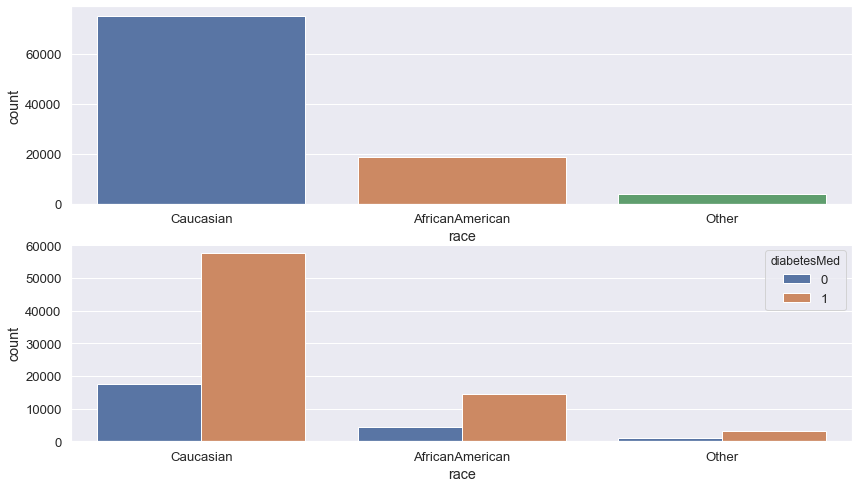

In [0]:
# Count plot of race by diabetesMed

f, axes = plt.subplots(2, 1, figsize=(14,8))
axes = axes.flatten()
sns.countplot(data['race'], ax=axes[0])
sns.countplot(data['race'],hue = data['diabetesMed'], ax=axes[1])

plt.show()



**Inferences:**

1.   The total number of Caucasians are signiicantly more than all other race.
2.   The race of Asians are least in number.
3.   80% of patients are belonging to other races are prescribed with diabetesMed.
4.   percentage of patients with medicine prescription  is more irrespective of the race.


4.422010769795619


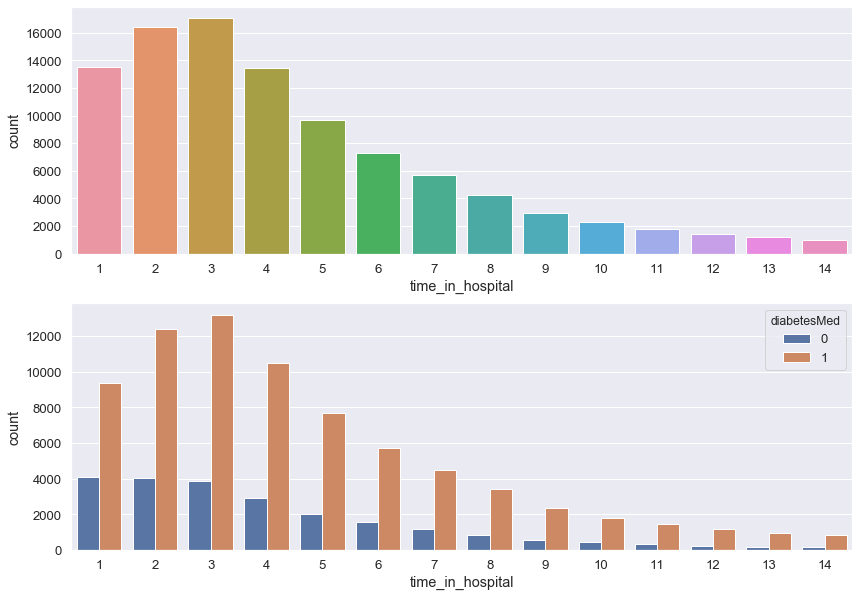

In [0]:
f, axes = plt.subplots(2, 1, figsize=(14,10))
axes = axes.flatten()
sns.countplot(data['time_in_hospital'],ax=axes[0])
sns.countplot(data['time_in_hospital'],hue = data['diabetesMed'], ax=axes[1])
print(data["time_in_hospital"].mean())
plt.show()

Inferences:
1.  The average number of days of admission is around 4 days.
2.  30% of the patienst whose number of days of time_in_hospital is "1" are not prescibed with diabeticMedication.


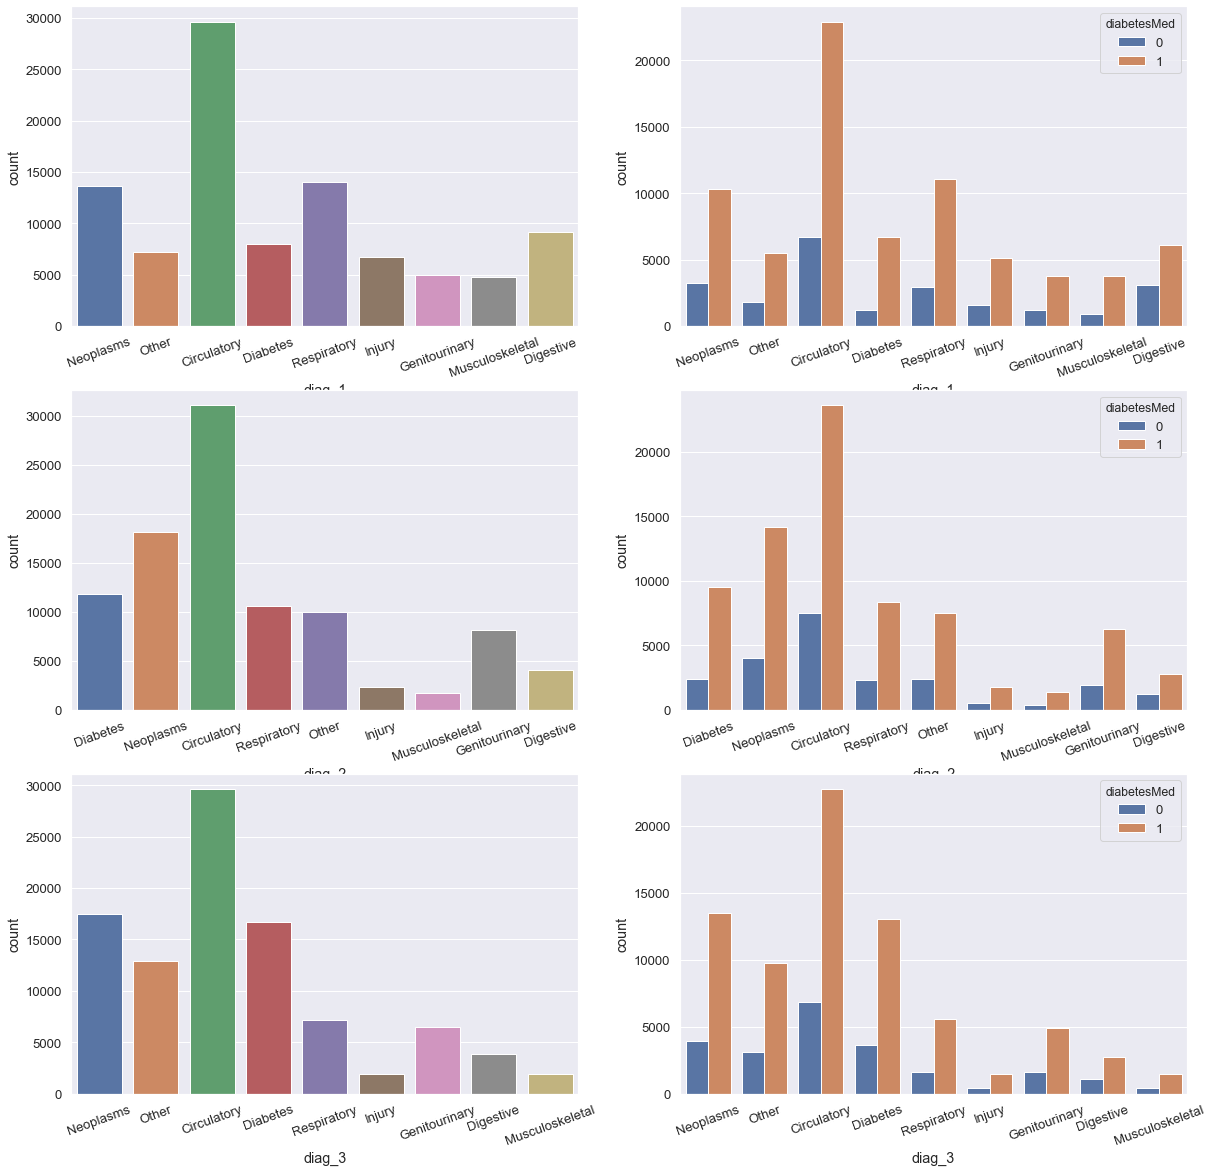

In [0]:
# Count plot of Primary diagnosis by readmission status

fig,ax = plt.subplots(3,2,figsize=(20,20))
ax = ax.flatten()

a=sns.countplot(data['diag_1'], ax=ax[0])
a.tick_params(alaxis="x",labelrotation=20)
b=sns.countplot(data['diag_1'],hue=data['diabetesMed'], ax=ax[1])
b.tick_params(axis="x",labelrotation=20)

c=sns.countplot(data['diag_2'], ax=ax[2])
c.tick_params(axis="x",labelrotation=20)
d=sns.countplot(data['diag_2'],hue=data['diabetesMed'], ax=ax[3])
d.tick_params(axis="x",labelrotation=20)
e=sns.countplot(data['diag_3'], ax=ax[4])
e.tick_params(axis="x",labelrotation=20)
f=sns.countplot(data['diag_3'],hue=data['diabetesMed'], ax=ax[5])
f.set_xticklabels(f.get_xticklabels(), rotation=20)
plt.show()

**Inferences:**
*   15%,19%,21% of patients who are diagnosed with diabetes in primary ,secondary ,Additional secondary diagnoses respectively are not prescribed with diabetesMedicine.
*   The total number of patients under the all diagnosis category of 'Circulatory' is maximum.

*   The total number of patients under the primary diagnosis categories of 'Neoplasms' and 'Respiratory' are almost equal.

*   Aprrox..70% of the patients diagnosed with other diseases are prescribed with diabetesMed

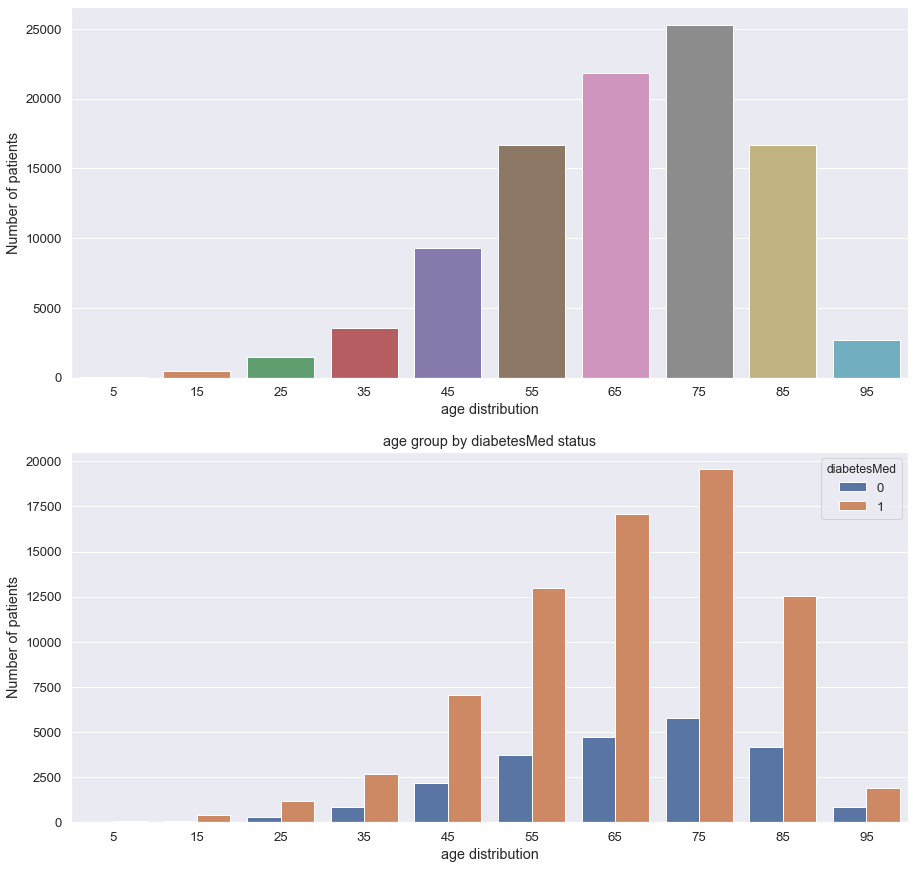

In [0]:
f, axes = plt.subplots(2, 1, figsize=(15,15))
axes = axes.flatten()
sns.countplot(data['age'], ax=axes[0])
axes[0].set_xlabel('age distribution')
axes[0].set_ylabel('Number of patients')
sns.countplot(data['age'],hue = data['diabetesMed'], ax=axes[1]).set_title('age group by diabetesMed status')
axes[1].set_xlabel('age distribution')
axes[1].set_ylabel('Number of patients')
plt.show()

**Inferences:**
1.   most of the patient admitting with age around 75 years.
2.   

In [0]:
data.A1Cresult.value_counts()

None        81859
veryhigh     7631
Norm         4854
high         3708
Name: A1Cresult, dtype: int64

In [0]:
admission_source = data['admission_source_id'].replace({1:'Admitted because of physician/clinic referral',2:'Admitted because of physician/clinic referral',
                                                       3:'Admitted because of physician/clinic referral',4:'Otherwise',
                                                       5:'Otherwise',
                                                       6:'Otherwise',
                                                       7:'Admitted from emergency room',8:'Otherwise',
                                                       9:'Otherwise',10:'Otherwise',
                                                       11:'Otherwise',13:'Otherwise',14:'Otherwise',
                                                       17:'Otherwise',20:'Otherwise',22:'Otherwise',
                                                       25:'Otherwise'})

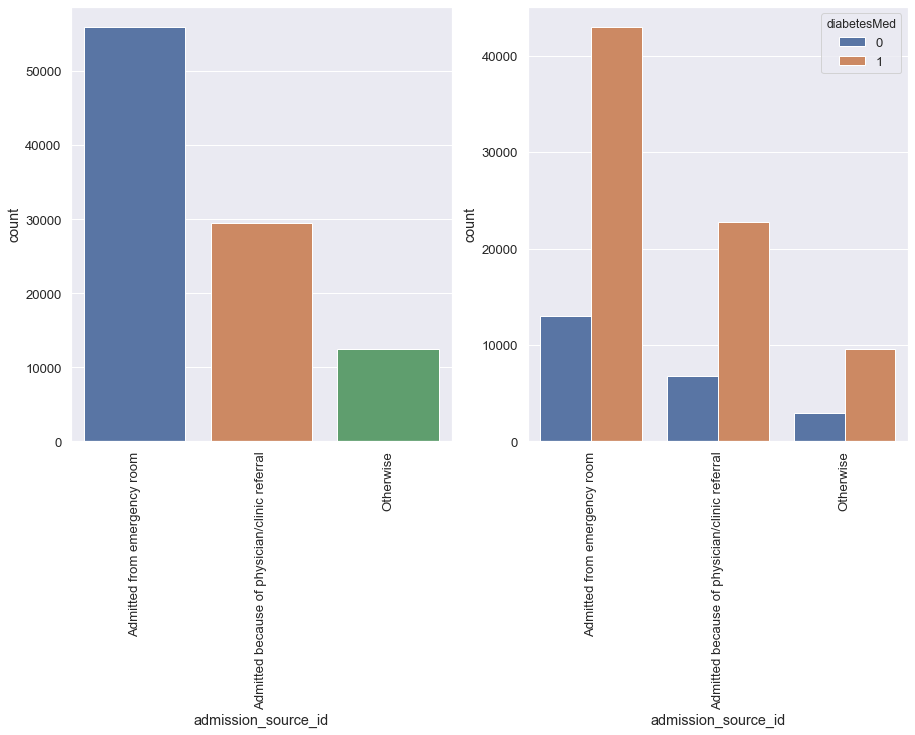

In [0]:
 fig,ax = plt.subplots(1,2,figsize=(15,8)) 
 ax = ax.flatten() 
 a=sns.countplot(admission_source,ax = ax[0])
 a.set_xticklabels(a.get_xticklabels(), rotation=90)
 b=sns.countplot(admission_source,hue = data['diabetesMed'],ax = ax[1]) 
 b.set_xticklabels(b.get_xticklabels(), rotation=90)
 plt.show()

**Inferences:**

1.   Pateints Admitted from emergency room are more in number than those admitted from any other admission source.
2.   


In [0]:
print(pd.crosstab(data.readmitted,data.A1Cresult))
pd.crosstab(data.readmitted,data.A1Cresult,normalize="columns")

A1Cresult    None  Norm  high  veryhigh
readmitted                             
0           43405  2814  2058      4060
1           29018  1566  1279      2786
2            9436   474   371       785


A1Cresult,None,Norm,high,veryhigh
readmitted,,,,
0,0.530241,0.579728,0.555016,0.53204
1,0.354488,0.322621,0.344930,0.36509
2,0.115271,0.097651,0.100054,0.10287


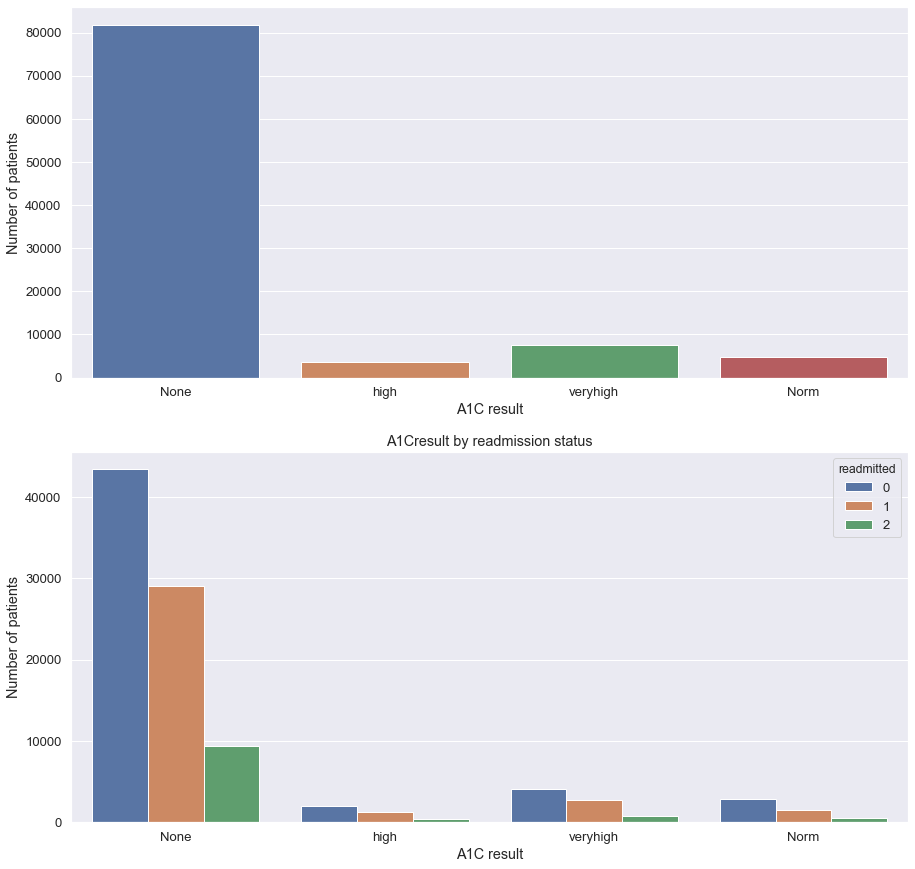

In [0]:
# Count plot for A1Cresult and medication changes

figsize(8,8)
f, axes = plt.subplots(2, 1, figsize=(15,15))
axes = axes.flatten()
sns.countplot(data['A1Cresult'], ax=axes[0])
axes[0].set_xlabel('A1C result')
axes[0].set_ylabel('Number of patients')
sns.countplot(data['A1Cresult'],hue = data['readmitted'], ax=axes[1]).set_title('A1Cresult by readmission status')
axes[1].set_xlabel('A1C result')
axes[1].set_ylabel('Number of patients')
plt.show()

**Inferences:**
* Number of patients those who did not take A1C test are higher.
* Approximately 88.5% of patients those who did not take A1C test and 80% of patients who took A1C test readmitted.
* 42.02% of patients readmitted whose A1C test result was Normal.

In [0]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,15,1,1,7,3,59,0,18,0,0,0,Neoplasms,Diabetes,Neoplasms,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,1
1,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,11,5,13,2,0,1,Other,Diabetes,Other,6,None,None,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,500364,82442376,Caucasian,Male,35,1,1,7,2,44,1,16,0,0,0,Neoplasms,Diabetes,Circulatory,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,0
3,16680,42519267,Caucasian,Male,45,1,1,7,1,51,0,8,0,0,0,Neoplasms,Neoplasms,Diabetes,5,None,None,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0
4,35754,82637451,Caucasian,Male,55,2,1,2,3,31,6,16,0,0,0,Circulatory,Circulatory,Diabetes,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1


diabetesMed      0      1
readmitted               
0            13402  38935
1             7092  27557
2             2208   8858


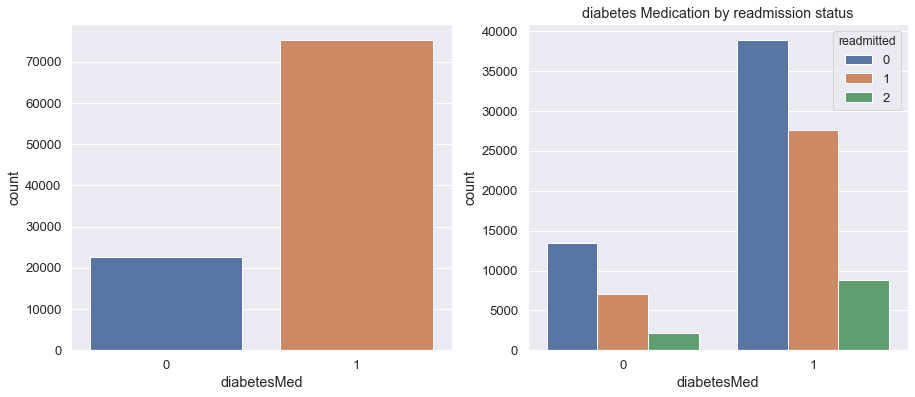

In [0]:
print(pd.crosstab(data.readmitted,data.diabetesMed))
f, axes = plt.subplots(1, 2, figsize=(15,6))
axes = axes.flatten()
sns.countplot(data['diabetesMed'], ax=axes[0])
axes[0].set_xlabel('diabetesMed')

sns.countplot(data['diabetesMed'],hue = data['readmitted'], ax=axes[1]).set_title('diabetes Medication by readmission status')
axes[1].set_xlabel('diabetesMed')

plt.show()

**Inferences**:
*  From the total data around 76% are took medications and in that 95% are readmitted.
*  Those who are didn't took medications around 67% are readmitted

max_glu_serum   None  Norm  high  veryhigh
readmitted                                
0              49676  1376   746       539
1              32755   866   519       509
2              10413   290   184       179


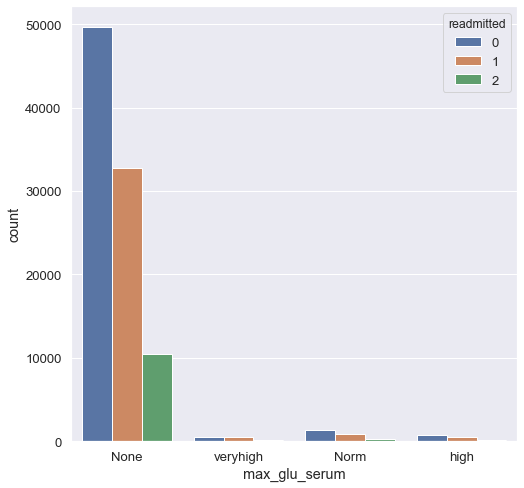

In [0]:
print(pd.crosstab(data.readmitted,data.max_glu_serum))
sns.countplot(data["max_glu_serum"],hue=data.readmitted)

**Inferences:**
*   Approx.,**95%** of patients are not taking max_glu_serum test
*   Approx.,**46%** of patients who didnt take test readmitted
*   Approx.,**56%** of the patients whose max_glu_serum values greater than 300 are readmitting

In [0]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

cols = ['race', 'diag_1', 'diag_2', 'diag_3',"A1Cresult","gender","max_glu_serum"]

for col in cols:
    data[col] = labelencoder.fit_transform(data[col])

In [0]:
data.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,1,0,15,1,1,7,3,59,0,18,0,0,0,6,1,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,1
1,64410,86047875,0,0,25,1,1,7,2,11,5,13,2,0,1,7,1,7,6,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,500364,82442376,1,1,35,1,1,7,2,44,1,16,0,0,0,6,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,0
3,16680,42519267,1,1,45,1,1,7,1,51,0,8,0,0,0,6,6,1,5,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0
4,35754,82637451,1,1,55,2,1,2,3,31,6,16,0,0,0,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1


0    0.468547
2    0.299515
1    0.120783
3    0.111155
Name: insulin, dtype: float64


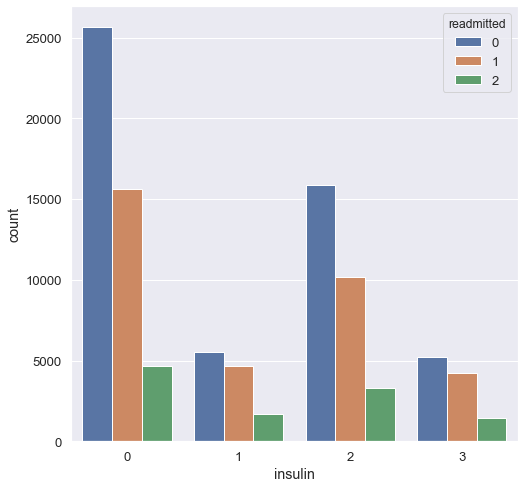

In [0]:
print(data.insulin.value_counts(normalize=True))
sns.countplot(data.insulin,hue=data.readmitted)

**Inferences:**
*    insulin was not prescribed for 46%  of the patiensts.
*    there is no change in insulin dosage for Aprox..30%.
*    readmission rate is more for the patients whose insulin dosage is either increase or decrease.


**Note:**
*    except insulin all other medications dosage was steady.

In [0]:
data.discharge_disposition_id.value_counts()

1     57609
3     13564
6     12626
18     3624
2      2049
22     1970
11     1606
5      1127
25      941
4       756
7       592
23      400
13      396
14      368
28      137
8       106
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

In [0]:
discharge_disposition = data['discharge_disposition_id'].replace({1:'discharged to home',2:'Otherwise',
                                                       3:'Otherwise',4:'Otherwise',
                                                       5:'Otherwise',
                                                       6:'discharged to home',
                                                       7:'Otherwise',8:'discharged to home',
                                                       9:'Otherwise',10:'Otherwise',
                                                       11:'Otherwise',12:'Otherwise',13:'Otherwise',14:'Otherwise',15:'Otherwise',16:'Otherwise',
                                                       17:'Otherwise',18:'Otherwise',19:'Otherwise',20:'Otherwise',22:'Otherwise',23:'Otherwise',24:'Otherwise',
                                                       25:'Otherwise',27:'Otherwise',28:'Otherwise',29:'Otherwise'})

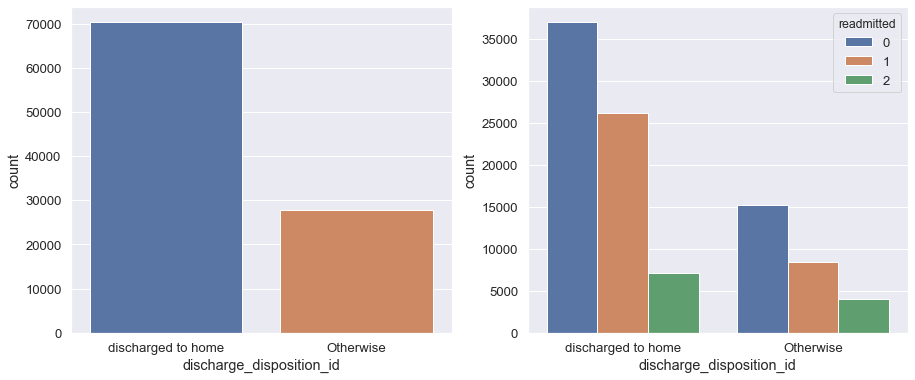

In [0]:
f, axes = plt.subplots(1, 2, figsize=(15,6))
axes = axes.flatten()
sns.countplot(discharge_disposition,ax=axes[0])


sns.countplot(discharge_disposition,hue = data['readmitted'], ax=axes[1])
plt.show()

Inferences:
*   approx..72% of patients discharged to home .
*   approx.. 73% of patients who dischaged to home are readmitted.

In [0]:
from sklearn.linear_model import LogisticRegression
new_df=data.copy()

In [0]:
new_df["discharge_disposition"] = data['discharge_disposition_id'].replace({1:'discharged to home',2:'Otherwise',
                                                       3:'Otherwise',4:'Otherwise',
                                                       5:'Otherwise',
                                                       6:'discharged to home',
                                                       7:'Otherwise',8:'discharged to home',
                                                       9:'Otherwise',10:'Otherwise',
                                                       11:'Otherwise',12:'Otherwise',13:'Otherwise',14:'Otherwise',15:'Otherwise',16:'Otherwise',
                                                       17:'Otherwise',18:'Otherwise',19:'Otherwise',20:'Otherwise',22:'Otherwise',23:'Otherwise',24:'Otherwise',
                                                       25:'Otherwise',27:'Otherwise',28:'Otherwise',29:'Otherwise'})
new_df["admission_source"] = data['admission_source_id'].replace({1:'Admitted because of physician/clinic referral',2:'Admitted because of physician/clinic referral',
                                                       3:'Admitted because of physician/clinic referral',4:'Otherwise',
                                                       5:'Otherwise',
                                                       6:'Otherwise',
                                                       7:'Admitted from emergency room',8:'Otherwise',
                                                       9:'Otherwise',10:'Otherwise',
                                                       11:'Otherwise',13:'Otherwise',14:'Otherwise',
                                                       17:'Otherwise',20:'Otherwise',22:'Otherwise',
                                                       25:'Otherwise'})
new_df["admission_type"] = data['admission_type_id'].replace({1:'Emergency', 2:'Urgent',
                                                       3:'Elective', 4:'Newborn',
                                                       5:'Not Available',
                                                       6:'NULL',
                                                       7:'Trauma Center',8:'Not Mapped'})


In [0]:
new_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,discharge_disposition,admission_source,admission_type
0,149190,55629189,1,0,15,1,1,7,3,59,0,18,0,0,0,6,1,6,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,1,discharged to home,Admitted from emergency room,Emergency
1,64410,86047875,0,0,25,1,1,7,2,11,5,13,2,0,1,7,1,7,6,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,discharged to home,Admitted from emergency room,Emergency
2,500364,82442376,1,1,35,1,1,7,2,44,1,16,0,0,0,6,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,1,1,0,discharged to home,Admitted from emergency room,Emergency
3,16680,42519267,1,1,45,1,1,7,1,51,0,8,0,0,0,6,6,1,5,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,discharged to home,Admitted from emergency room,Emergency
4,35754,82637451,1,1,55,2,1,2,3,31,6,16,0,0,0,0,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,discharged to home,Admitted because of physician/clinic referral,Urgent


In [0]:
new_df.drop(["admission_source_id","discharge_disposition_id"],axis=1,inplace=True)

In [0]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

cols = ['discharge_disposition', 'admission_source',"gender","admission_type"]

for col in cols:
    new_df[col] = labelencoder.fit_transform(new_df[col])

In [0]:
new_df.drop(["encounter_id","patient_nbr","admission_type_id"],axis=1,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split
X=new_df.drop(["diabetesMed"],axis=1)
y=new_df["diabetesMed"]
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=0,stratify=y)
model=LogisticRegression()
model.fit(x_train,y_train)
print('Training score =', model.score(x_train, y_train))
print('Test score =', model.score(x_test, y_test))

Training score = 0.9955416982341628
Test score = 0.9958865923307044


C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler()
x_train=mm.fit_transform(x_train,y)
x_test=mm.transform(x_test)
model=LogisticRegression()
model.fit(x_train,y_train)
print('Training score =', model.score(x_train, y_train))
print('Test score =', model.score(x_test, y_test))

Training score = 0.9997377469549508
Test score = 0.9996260538482459


In [0]:
#new_df =new_df[~new_df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [0]:
X = new_df.drop('diabetesMed', axis=1)
y= new_df['diabetesMed']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=0)
logreg = LogisticRegression(fit_intercept=True,solver="liblinear")
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=10))))
logreg.fit(X_train, Y_train)
print("test Set score: {:.2%}".format(logreg.score(X_test, Y_test)))

Cross Validation Score: 99.99%
test Set score: 99.97%


In [0]:
Y_test_predict = logreg.predict(X_test)

In [0]:
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(Y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,539,1801,2340
1,1466,4984,6450
All,2005,6785,8790


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_test_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_test_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_test_predict)))

Accuracy is 1.00
Precision is 1.00
Recall is 1.00


In [0]:
from imblearn.over_sampling import SMOTE

from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
sm = SMOTE(random_state=20)
X_new, y_new = sm.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({1: 75350, 0: 22702})
New dataset shape Counter({1: 75350, 0: 75350})


In [0]:
X_new = pd.DataFrame(X_new, columns = list(X.columns))

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X_new, y_new, test_size=0.30, random_state=0)
logreg = LogisticRegression(fit_intercept=True,solver="liblinear")
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(logreg, X_train, Y_train, cv=10))))
logreg.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(logreg.score(X_test, Y_test)))

Cross Validation Score: 100.00%
Dev Set score: 100.00%


In [0]:
Y_test_predict = logreg.predict(X_test)

In [0]:
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(Y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,1751,1735,3486
1,4992,5037,10029
All,6743,6772,13515


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_test_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_test_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_test_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_test, Y_test_predict)))

accuracy_logreg = accuracy_score(Y_test, Y_test_predict)
precision_logreg = precision_score(Y_test, Y_test_predict)
recall_logreg = recall_score(Y_test, Y_test_predict)
auc_logreg = roc_auc_score(Y_test, Y_test_predict)

Accuracy is 1.00
Precision is 1.00
Recall is 1.00
AUC is 1.00


In [0]:
import statsmodels.api as sm
logit = sm.Logit(Y_train, X_train)

result = logit.fit(method="cg")

# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

print(result.summary())
logit_coefs = pd.DataFrame(result.params)
logit_coefs.reset_index(inplace=True)
logit_coefs.columns = ["Feature", "Coefficient"]
logit_pvals = pd.DataFrame(result.pvalues)
logit_pvals.reset_index(inplace=True)
logit_pvals.columns = ["Feature", "pVal"]

logit_coefs = logit_coefs.merge(logit_pvals, how="inner", on=["Feature"])
logit_coefs = logit_coefs[logit_coefs.pVal <0.01]
logit_coefs.sort_values(by='Coefficient', ascending=False)

         Current function value: 0.221970
         Iterations: 35
         Function evaluations: 73
         Gradient evaluations: 73


C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                           Logit Regression Results                           
Dep. Variable:            diabetesMed   No. Observations:               105490
Model:                          Logit   Df Residuals:                   105451
Method:                           MLE   Df Model:                           38
Date:                Thu, 26 Dec 2019   Pseudo R-squ.:                  0.6798
Time:                        14:18:57   Log-Likelihood:                -23416.
converged:                      False   LL-Null:                       -73118.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
race                         0.1559        nan        nan        nan         nan         nan
gender                       0.2766        nan        nan        nan         nan         

,Feature,Coefficient,pVal


## Decision Tree

In [0]:
X = new_df.drop('diabetesMed', axis=1)
y= new_df['diabetesMed']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=0)
from sklearn.tree import DecisionTreeClassifier
dte = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(dte, X_train, Y_train, cv=10))))
dte.fit(X_train, Y_train)
print("test Set score: {:.2%}".format(dte.score(X_test, Y_test)))

Cross Validation score: 99.99%
test Set score: 100.00%


In [0]:
Y_test_predict = dte.predict(X_test)
 

In [0]:
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(Y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,538,1802,2340
1,1465,4985,6450
All,2003,6787,8790


In [0]:
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_test_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_test_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_test_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_test, Y_test_predict)))

accuracy_dte = accuracy_score(Y_test, Y_test_predict)
precision_dte = precision_score(Y_test, Y_test_predict)
recall_dte = recall_score(Y_test, Y_test_predict)
auc_dte = roc_auc_score(Y_test, Y_test_predict)

Accuracy is 1.00
Precision is 1.00
Recall is 1.00
AUC is 1.00


                Feature  Importance
18          nateglinide    0.013118
34  glyburide-metformin    0.015410
17          repaglinide    0.025711
20          glimepiride    0.058817
26        rosiglitazone    0.059960
25         pioglitazone    0.060748
22            glipizide    0.098516
23            glyburide    0.105419
16            metformin    0.148317
33              insulin    0.398769


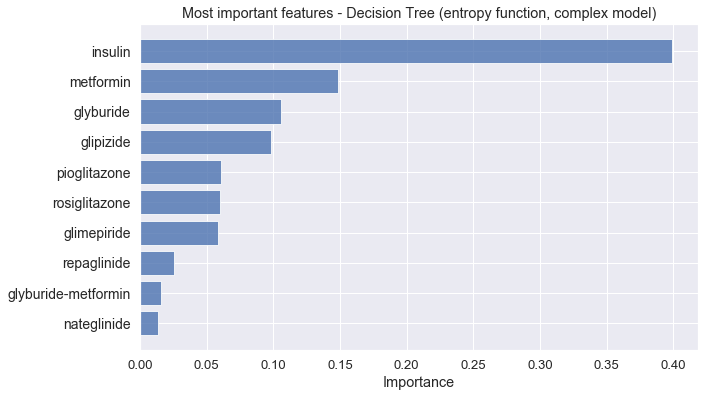

In [0]:
feature_names = X_train.columns
feature_imports = dte.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree (entropy function, complex model)')
plt.show()

In [0]:
dtg = DecisionTreeClassifier(max_depth=28, criterion = "gini", min_samples_split=10)
print("Cross Validation Score: {:.2%}".format(np.mean(cross_val_score(dtg, X_train, Y_train, cv=10))))
dtg.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(dtg.score(X_test, Y_test)))

Cross Validation Score: 99.99%
Dev Set score: 100.00%


In [0]:

Y_test_predict = dtg.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_test_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_test_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_test_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_test, Y_test_predict)))

accuracy_dtg = accuracy_score(Y_test, Y_test_predict)
precision_dtg = precision_score(Y_test, Y_test_predict)
recall_dtg = recall_score(Y_test, Y_test_predict)
auc_dtg = roc_auc_score(Y_test, Y_test_predict)


Accuracy is 1.00
Precision is 1.00
Recall is 1.00
AUC is 1.00


## Random Forest

In [0]:
X = new_df.drop('diabetesMed', axis=1)
y= new_df['diabetesMed']

# Data balancing applied using SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))
train_input_new = pd.DataFrame(train_input_new, columns = list(X.columns))
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Original dataset shape Counter({1: 75350, 0: 22702})
New dataset shape Counter({1: 75350, 0: 75350})


In [0]:
from sklearn.ensemble import RandomForestClassifier
forrest = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(forrest, X_train, Y_train, cv=10))))
forrest.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(forrest.score(X_test, Y_test)))

Cross Validation score: 99.93%
Dev Set score: 99.93%


In [0]:
Y_test_predict = forrest.predict(X_test)
pd.crosstab(pd.Series(Y_test, name = 'Actual'), pd.Series(Y_test_predict, name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,538,1802,2340
1,1467,4983,6450
All,2005,6785,8790


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_test_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_test_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_test_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_test, Y_test_predict)))

accuracy_forrestg = accuracy_score(Y_test, Y_test_predict)
precision_forrestg = precision_score(Y_test, Y_test_predict)
recall_forrestg = recall_score(Y_test, Y_test_predict)
auc_forrestg = roc_auc_score(Y_test, Y_test_predict)


Accuracy is 1.00
Precision is 1.00
Recall is 1.00
AUC is 1.00


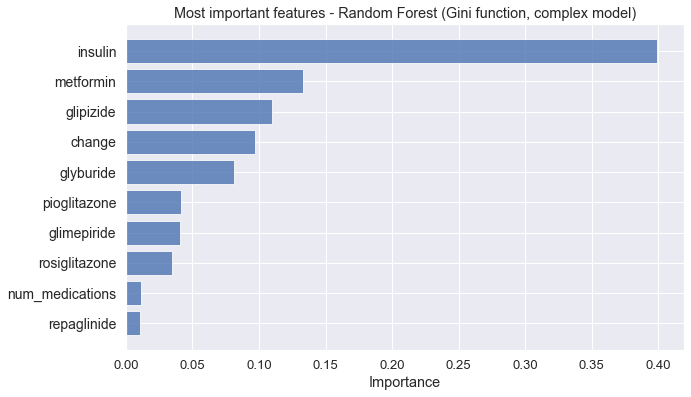

In [0]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = forrest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Gini function, complex model)')
plt.show()

In [0]:
from sklearn.ensemble import RandomForestClassifier
forrest = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
print("Cross Validation score: {:.2%}".format(np.mean(cross_val_score(forrest, X_train, Y_train, cv=10))))
forrest.fit(X_train, Y_train)
print("Dev Set score: {:.2%}".format(forrest.score(X_test, Y_test)))

Cross Validation score: 99.90%
Dev Set score: 99.90%


In [0]:
Y_test_predict = forrest.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
print("Accuracy is {0:.2f}".format(accuracy_score(Y_test, Y_test_predict)))
print("Precision is {0:.2f}".format(precision_score(Y_test, Y_test_predict)))
print("Recall is {0:.2f}".format(recall_score(Y_test, Y_test_predict)))
print("AUC is {0:.2f}".format(roc_auc_score(Y_test, Y_test_predict)))

accuracy_forreste = accuracy_score(Y_test, Y_test_predict)
precision_forreste = precision_score(Y_test, Y_test_predict)
recall_forreste = recall_score(Y_test, Y_test_predict)
auc_forreste = roc_auc_score(Y_test, Y_test_predict)

Accuracy is 1.00
Precision is 1.00
Recall is 1.00
AUC is 1.00


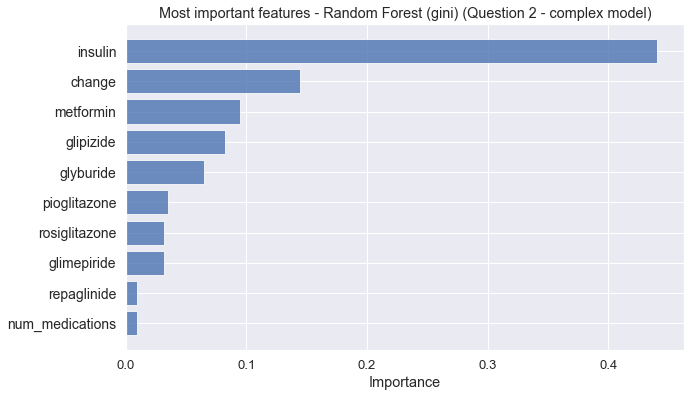

In [0]:

# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = forrest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (gini) (Question 2 - complex model)')
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a 

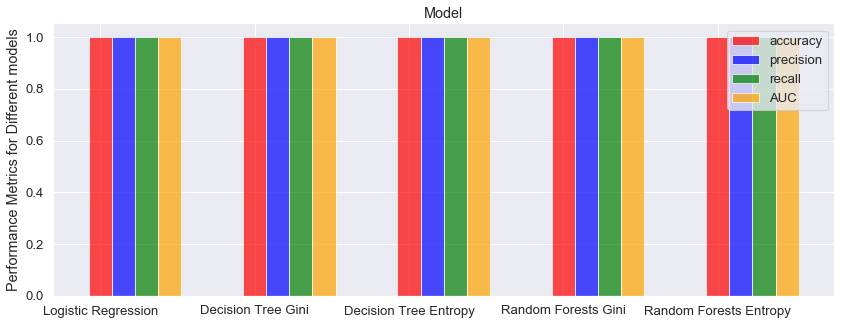

In [0]:
# plotting the accuracy for training and test
plt.figure(figsize=(14, 5))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree Gini', 'Decision Tree Entropy', 'Random Forests Gini', 'Random Forests Entropy' ]
values = [accuracy_logreg, accuracy_dtg, accuracy_dte, accuracy_forrestg, accuracy_forreste]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'red', label= 'accuracy')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree Gini', 'Decision Tree Entropy', 'Random Forests Gini', 'Random Forests Entropy' ]
values = [precision_logreg, precision_dtg, precision_dte, precision_forrestg, precision_forreste]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree Gini', 'Decision Tree Entropy', 'Random Forests Gini', 'Random Forests Entropy' ]
values = [recall_logreg, recall_dtg, recall_dte, recall_forrestg, recall_forreste]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)



ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree Gini', 'Decision Tree Entropy', 'Random Forests Gini', 'Random Forests Entropy' ]
values = [auc_logreg, auc_dtg, auc_dte, auc_forrestg, auc_forreste]
model = np.arange(len(models))

plt.bar(model+0.45, values, align='center', width = 0.15, alpha=0.7, color = 'orange', label = 'AUC')
plt.xticks(model, models)



plt.ylabel('Performance Metrics for Different models')
plt.title('Model')
    
# removing the axis on the top and right of the plot window
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

plt.show()